In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.decomposition import PCA

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
data_batch=[]
for i in range(1,6):
    data_batch.append(unpickle('cifar-10-batches-py/data_batch_'+str(i)))
data_batch.append(unpickle('cifar-10-batches-py/test_batch'))

In [7]:
label_names=unpickle('cifar-10-batches-py/batches.meta')[b'label_names']
label_names

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [9]:
data=[]
for i in range(len(data_batch)):
    data=np.append(data,data_batch[i][b'data'])
data=np.reshape(data,(60000,3072))
data.shape

(60000, 3072)

In [11]:
labels=np.array([],dtype=int)
for i in range(len(data_batch)):
    labels=np.append(labels,data_batch[i][b'labels'])
labels=np.reshape(labels,60000)
labels=np.array(labels,dtype=int)
len(labels)

60000

In [13]:
dataByCat=[[],[],[],[],[],[],[],[],[],[]] 
for ind,l in enumerate(labels):
    dataByCat[l].append(data[ind])

In [14]:
def printImage(data):
    r=data[:1024]
    g=data[1024:2048]
    b=data[2048:]
    new_r=np.reshape(r,(32,32))
    new_g=np.reshape(g,(32,32))
    new_b=np.reshape(b,(32,32))
    im=np.dstack((new_r,new_g,new_b))
    im /= 255
    plt.imshow(im)
    plt.show()

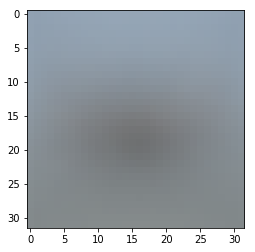

array([ 145.46483333,  144.43483333,  145.118     , ...,  138.5875    ,
        138.34583333,  138.8415    ])

In [30]:
mean_images=[]

for cat in range(len(dataByCat)):
    mean_images.append(np.mean(dataByCat[cat], axis = 0))
    
printImage(mean_images[0])
mean_images[0]


In [48]:
def get_error_from_pca(mean, components, data):
    pca = PCA(n_components=20)
    #pca.fit(data)
    pca.mean_ = mean
    pca.components_ = components
    pca_20 = pca.transform(data)
    im_first_20 = pca.inverse_transform(pca_20)
    difference = im_first_20 - data
    difference *= difference
    error = sum(sum(difference)) / len(data)
    return error
    

In [35]:
class_info = []
errors = []
for cat in range(len(dataByCat)):
    pca=PCA(n_components=20)
    pca.fit(dataByCat[cat])
    class_info.append((pca.mean_, pca.components_, dataByCat[cat]))
    pca_20 = pca.transform(dataByCat[cat])
    im_first_20 = pca.inverse_transform(pca_20)
    difference = im_first_20 - dataByCat[cat]
    difference *= difference
    error = sum(sum(difference)) / len(dataByCat[cat])
    errors.append(error)

In [39]:
def create_error_distance_matrix(class_info):
    dis_matrix = np.zeros((len(class_info), len(class_info)))
    for class_num_A, (mean_A, comp_A, data_A) in enumerate(class_info):
        for class_num_B, (mean_B, comp_B, data_B) in enumerate(class_info):
            error_A_approx_B = get_error_from_pca(mean_A, comp_B, data_A)
            error_B_approx_A = get_error_from_pca(mean_B, comp_A, data_B)
            dis_matrix[class_num_A][class_num_B] = (error_B_approx_A + error_A_approx_B)*0.5
    return dis_matrix

In [23]:
def create_euclidean_distance_matrix(mean_images):
    dis_matrix = np.zeros((len(mean_images), len(mean_images)))
    for label_x, image_x in enumerate(mean_images):
        for label_y, image_y in enumerate(mean_images):
            temp_image = image_x - image_y
            dis_matrix[label_x][label_y] = np.linalg.norm(temp_image, ord=2)
    return dis_matrix
        

In [49]:
similarities = create_euclidean_distance_matrix(mean_images)
mds = manifold.MDS(n_components = 2, dissimilarity = "precomputed")
pos = mds.fit_transform(similarities)

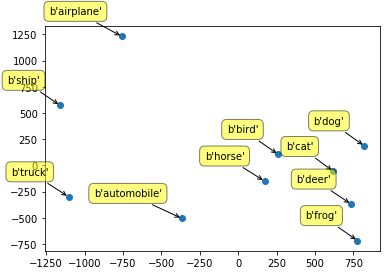

In [26]:
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    pos[:, 0], pos[:, 1], marker='o')

for label, x, y in zip(label_names, pos[:, 0], pos[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()similarities = create_euclidean_distance_matrix(mean_images)
mds = manifold.MDS(n_components = 2, dissimilarity = "precomputed")
pos = mds.fit_transform(similarities)

In [50]:
dis_matrix = create_error_distance_matrix(class_info)
mds = manifold.MDS(n_components = 2, dissimilarity = "precomputed")
pos = mds.fit_transform(dis_matrix)

In [52]:
np.diag(dis_matrix) - errors

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

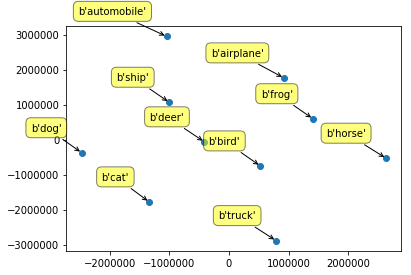

In [53]:
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    pos[:, 0], pos[:, 1], marker='o')

for label, x, y in zip(label_names, pos[:, 0], pos[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()